In [5]:
import librosa
import librosa.display
import os
import numpy as np
from scipy.signal import get_window
from sklearn import preprocessing
import python_speech_features as mfcc
from sklearn.mixture import GaussianMixture 
import pickle
import matplotlib.pyplot as plt

## Feartures Extraction

##### MFCC Feature

In [6]:
def calculate_delta(array):

    rows,cols = array.shape
    print(rows)
    print(cols)
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first =0
            else:
                first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(file_path):
    audio , sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfcc_feature = mfcc.mfcc(audio,sample_rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    print(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

In [7]:
featuresMagdy = []
directory = './files/magdy/'
for audio in os.listdir('./files/magdy/'):
    audio_path = directory + audio
    featuresMagdy=np.vstack(extract_features(audio_path) )

featuresMayar = []
directory = './files/mayar/'
for audio in os.listdir('./files/mayar/'):
    audio_path = directory + audio
    featuresMayar=np.vstack(extract_features(audio_path) )

featuresMina = []
directory = './files/Mina/'
for audio in os.listdir('./files/Mina/'):
    audio_path = directory + audio
    featuresMina=np.vstack(extract_features(audio_path) )

featuresMostafa = []
directory = './files/mostafa/'
for audio in os.listdir('./files/mostafa/'):
    audio_path = directory + audio
    featuresmostafa=np.vstack(extract_features(audio_path) )

openFeatures = []
directory = './files/open/'
for audio in os.listdir('./files/open/'):
    audio_path = directory + audio
    openFeatures=np.vstack(extract_features(audio_path) )

[[-7.91992823 -0.66404255  0.57778965 ... -0.27422259  0.32637156
  -0.26516168]
 [ 0.04659459 -1.19293613  0.15763368 ... -1.52297596 -1.77926834
  -0.13066189]
 [ 0.14763796 -0.93281379  0.43245004 ... -0.01044203 -0.87744672
   0.27923887]
 ...
 [-0.29704029 -0.47026839 -0.28251217 ... -0.08028219 -0.2226013
  -0.23090943]
 [-0.32081529 -0.55214895 -0.50035371 ...  0.337615    0.60050052
   1.14368717]
 [-0.27192963 -1.12953205  0.71668418 ... -0.08777595  1.41933114
   0.11957042]]
293
20
[[-6.67364825 -0.49999698  1.27784003 ...  0.32926788  0.71142323
  -0.05300399]
 [-0.9318828  -0.6413264   0.43033865 ...  0.83710909 -1.54953062
  -0.63201934]
 [-0.70443959 -0.77129068  0.26439506 ...  0.57853023 -1.54458441
  -0.16453628]
 ...
 [-0.34373986 -0.54836766 -0.72551409 ...  1.90838242  1.56241673
  -1.77223937]
 [-0.39529294 -0.47111005 -0.73087077 ...  2.55605932  1.05280278
  -1.43919271]
 [-0.57720455 -0.48700847 -0.42136471 ...  1.88619893  0.21404162
  -1.78745783]]
293
20
[[-

In [8]:
magdy_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
magdy_gmm.fit(featuresMagdy)

mayar_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
mayar_gmm.fit(featuresMayar)

mina_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
mina_gmm.fit(featuresMina)

mostafa_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
mostafa_gmm.fit(featuresmostafa)

open_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
open_gmm.fit(openFeatures)

GaussianMixture(covariance_type='diag', max_iter=2000, n_components=6, n_init=3)

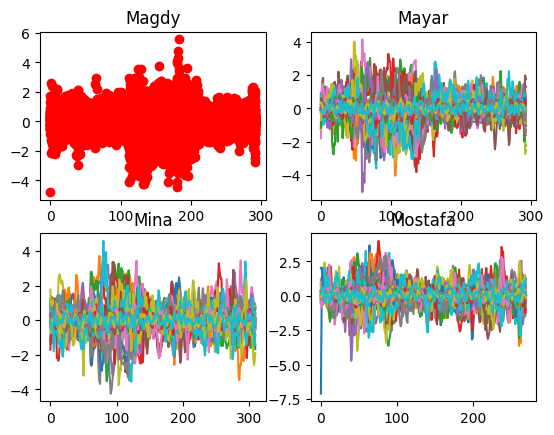

In [9]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(featuresMagdy,'ro')
axis[0, 0].set_title("Magdy")

# For Cosine Function
axis[0, 1].plot(featuresMayar)
axis[0, 1].set_title("Mayar")

# For Tangent Function
axis[1, 0].plot(featuresMina)
axis[1, 0].set_title("Mina")

# For Tanh Function
axis[1, 1].plot(featuresmostafa)
axis[1, 1].set_title("Mostafa")

names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

# Combine all the operations and display
plt.show()

In [10]:
pickle.dump(mayar_gmm,open('mayar.gmm','wb'))
pickle.dump(mina_gmm,open('mina.gmm','wb'))
pickle.dump(magdy_gmm,open('magdy.gmm','wb'))
pickle.dump(mostafa_gmm,open('mostafa.gmm','wb'))
pickle.dump(open_gmm,open('open.gmm','wb'))

In [11]:
test = extract_features('./files/test/.magdy_test_1.wav')

[[-6.23181134  0.06484397  0.58918454 ...  0.38103895  0.55428167
  -0.49697659]
 [-0.1196325  -2.31669386  0.65715876 ...  1.31532183  1.53700142
   0.23591274]
 [ 0.14348047 -1.97116466  0.69343498 ...  1.21424472  1.18825169
  -0.8700939 ]
 ...
 [ 0.45006605 -1.46346407 -2.13764065 ...  1.05199199 -1.16805713
  -0.54094215]
 [ 0.36448229 -0.92188896 -1.27988075 ...  1.43265068 -0.97487533
  -0.50519503]
 [ 0.22815549 -1.40567788 -1.91131402 ...  1.08598233 -1.54483275
  -1.32679634]]
297
20


In [12]:
scores_1=np.array(open_gmm.score(test))
scores_2=np.array(magdy_gmm.score(test))
scores_3=np.array(mayar_gmm.score(test))
scores_4=np.array(mina_gmm.score(test))
scores_5=np.array(mostafa_gmm.score(test))


print(scores_1)
print(scores_2)
print(scores_3)
print(scores_4)
print(scores_5)


-30.051980500207083
-27.288187939457725
-32.843376432573365
-30.945831469303933
-33.34307084050026
